## Basic Packages

In [1]:
import pandas as pd

from shapely.geometry import Point, Polygon

import geopandas as gp

import numpy as np

import random

import pulp

import folium

import networkx as nx

import math

import h3

import os,sys

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import copy

## Spatial Class

In [2]:
'''Hexagonal classes'''

class Hexagon(object):
    
    '''
    Functions:
    
    (1) convert geographical coordinates to hexgon
    
    (2) Generate a set of neighbor hexagons for the given hexgon
    
    '''
    
    def __init__(self,resolution):
        
        self.resolution=resolution
        
    def Get_Hex(self,lat,lng):
        
        '''
        Input: latitude,longitude
        
        Output: hexgon
        
        '''
        
        return h3.geo_to_h3(lat,lng,self.resolution)
    
    def Get_Neigh(self,hexgon,radius):
        
        '''
        Input: central hexgon,radius
        
        Output: set of neighbor hexgons
        
        '''
        
        y= h3.hex_range_distances(hexgon, radius)
        
        x=list()
        for y_ in y:
            for y__ in y_:
                x.append(y__)
        return x
    
    def Compact_lists(self,hexagons):
        
        '''
        Input: list of hexgons
        
        Output: set of hexgons
        
        '''
        
        result=list()
    
        for a in hexagons:

            result=list(set(result+a))

        return result
    
    def Center_point(self,hexagon):
        
        return [p for p in h3.h3_to_geo(hexagon)]
    
    def Sample_point(self,hexagon):
        
        '''
        Input: hexgon
        
        Output: point
        
        '''
        
        boundary=h3.h3_to_geo_boundary(hexagon)
        poly = Polygon(boundary)
        (minx, miny, maxx, maxy) = poly.bounds
        while True:
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if poly.contains(p):
                return [list(p.coords)[0][0],list(p.coords)[0][1]]

## Basic parameter

In [3]:
'''Systemic paths'''

Load_path='./Data/NYC_Network/'


'''Parameters'''

Start_step=2520 # Start stamp 

End_step=3600 # End stamp 


'''Network data'''

'''Grid-related data'''

Grid_list=np.load(os.path.join(Load_path,'Grids.npy'),allow_pickle=True)

Grid_Point=np.load(os.path.join(Load_path,'Grid_Point.npy'),allow_pickle=True).item()

'''Point-related data'''

Points_list=np.load(os.path.join(Load_path,'Points_list.npy'),allow_pickle=True)

Link_Point=np.load(os.path.join(Load_path,'Link_Point.npy'),allow_pickle=True).item()

Point_coordinate=np.load(os.path.join(Load_path,'Point_coordinate.npy'),allow_pickle=True).item()

Point_Grid=np.load(os.path.join(Load_path,'Point_Grid.npy'),allow_pickle=True).item()


resolution=9


Hex=Hexagon(resolution)

Save_path = './Real_World/'


'''Generation data'''

ini_num=150

## Spatial Range

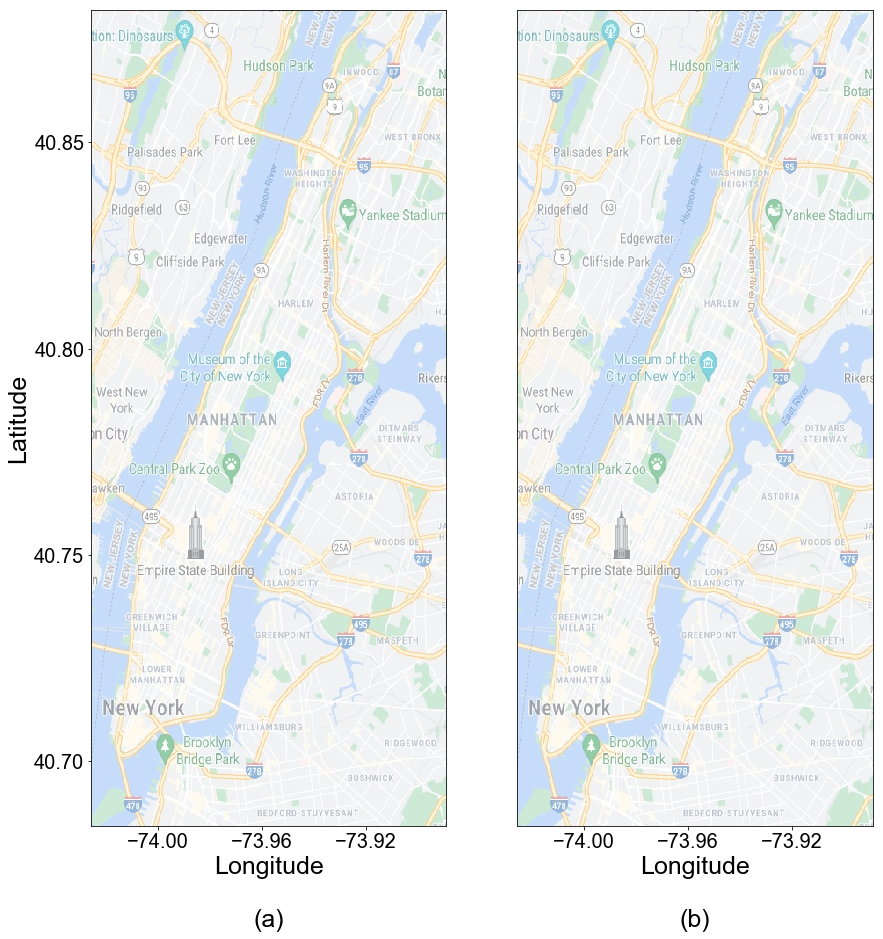

In [4]:
Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./Data/Map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

tags=['\n\n(a)','\n\n(b)']


def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 14,15
    
    figure, ax1 = plt.subplots(1,2,figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    
    for i in range(2):

        labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Arial') for label in labels]
        
        ax1[i].set_xlim(xgrange)
        
        ax1[i].set_ylim(ygrange)
        
        x0,x1 = ax1[i].get_xlim()
        
        y0,y1 = ax1[i].get_ylim()
    
        ax1[i].imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
        
        ax1[i].set_xlabel('Longitude'+tags[i],font_label)
        
        xmajorLocator   = MultipleLocator(0.04)

        ax1[i].xaxis.set_major_locator(xmajorLocator)

        if i>0:
        
            ax1[i].set_yticks([])
            
        else:
            
            ax1[i].set_ylabel('Latitude',font_label)
            
            ymajorLocator1   = MultipleLocator(0.05)

            ax1[i].yaxis.set_major_locator(ymajorLocator1)
    
    return figure, ax1


figure, ax1=Background('NYC',Southwest,Northeast)


In [5]:
Center=Point(-73.955575,40.782341)

Lower=Point(-73.991472,40.732128)

def Get_POLYGON(coords):
    
    if coords.type=='Polygon':
        
        return coords
    
    else:
        
        Score={i:coords[i].area for i in range(len(coords))}
        
        idx=max(Score, key=Score.get)
        
        return coords[idx]

    
def Get_distance(point1,point2):
    
    return point1.distance(point2)*111000*1.2


Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data['distance']=Zone_data.apply(lambda x:Get_distance(x['center'],Center),axis=1)

Zone_data['Label']='C'

Zone_data['Label']=Zone_data.apply(lambda x:'B' if x['distance'] <5000 else x['Label'], axis=1)

Zone_data['distance']=Zone_data.apply(lambda x:Get_distance(x['center'],Lower),axis=1)

Zone_data['Label']=Zone_data.apply(lambda x:'A' if x['distance'] <6000 and x['Label'] !='B' else x['Label'], axis=1)

Zone_data

Zone_label={}

Grid_label={}

Grid_Records=[]

for idx,row in Zone_data.iterrows():
    
    zone=row['zone']
    
    label=row['Label']
    
    geometry=row['geometry']
    
    Zone_label[zone]=label
    
    for grid in Grid_list:
        
        center=Point(h3.h3_to_geo(str(grid))[::-1])
        
        if grid not in Grid_Records:
        
            if geometry.contains(center):

                Grid_label[grid]=label

                Grid_Records.append(grid)
            
            
            

In [6]:
Street_data = gp.read_file('./Data/NYC_Street/geo_export_2d0a9cb9-782e-42c0-ba15-7345a0f64002.shp')

Street_data=Street_data.loc[(Street_data['borocode']=='1')&(Street_data['rw_type'].isin([1,3]))&(Street_data['status']=='2')]

Street_data=Street_data[['st_name','geometry','shape_leng']]

Street_data=Street_data.rename(columns={'shape_leng':'length'})

Street_data['start']=Street_data.apply(lambda x:list(x['geometry'].coords)[0][::-1],axis=1)

Street_data['end']=Street_data.apply(lambda x:list(x['geometry'].coords)[-1][::-1],axis=1)

Street_data['start_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['start'][0],x['start'][1],resolution),axis=1)

Street_data['end_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['end'][0],x['end'][1],resolution),axis=1)

Street_data=Street_data.loc[(Street_data['start_grid'].isin(Grid_label.keys()))&(Street_data['end_grid'].isin(Grid_label.keys()))]

Street_data['tag']=Street_data.apply(lambda x:Grid_label[x['start_grid']],axis=1)
                        
Street_data=Street_data.reset_index(drop=True)

Street_data



st_name                                           geometry  \
0         BENNETT  LINESTRING (-73.93666 40.85045, -73.93620 40.8...   
1           STONE  LINESTRING (-74.01007 40.70455, -74.00975 40.7...   
2            GOLD  LINESTRING (-74.00684 40.70786, -74.00653 40.7...   
3             109  LINESTRING (-73.94969 40.79622, -73.94919 40.7...   
4       AMSTERDAM  LINESTRING (-73.93192 40.84671, -73.93185 40.8...   
...           ...                                                ...   
9180        TENTH  LINESTRING (-73.99042 40.76656, -73.98996 40.7...   
9181           42  LINESTRING (-73.99394 40.75898, -73.99547 40.7...   
9182      HOUSTON  LINESTRING (-73.98944 40.72308, -73.98879 40.7...   
9183        WORTH  LINESTRING (-74.00211 40.71516, -74.00131 40.7...   
9184  ADAM POWELL  LINESTRING (-73.93549 40.82673, -73.93533 40.8...   

          length                                     start  \
0     735.721079   (40.85044732520501, -73.93666142761384)   
1     122.538700  (40.704545914131955, -74.01006968341342)   
2     159.149459   (40.707857835737876, -74.0068377870997)   
3     508.092565   (40.79621698487826, -73.94968682996546)   
4      38.069869    (40.8467105236121, -73.93191507377053)   
...          ...                                       ...   
9180  261.032634   (40.76656125816019, -73.99042168018246)   
9181  487.040405   (40.75897926882782, -73.99393650669813)   
9182  193.415131   (40.72308392217512, -73.98943880748347)   
9183  260.014217   (40.71515891016285, -74.00211455770949)   
9184  326.475365   (40.82672573484124, -73.93548534289174)   

                                           end       start_grid  \
0     (40.852335152313174, -73.93571740885848)  892a100ae77ffff   
1      (40.70477524791872, -74.00974639311217)  892a1072817ffff   
2      (40.70822712625459, -74.00653116871753)  892a1072887ffff   
3     (40.795536417729416, -73.94808516529754)  892a1008d73ffff   
4      (40.84680263276957, -73.93185010295767)  892a100ae2bffff   
...                                        ...              ...   
9180    (40.76718747461626, -73.9899638269705)  892a1072597ffff   
9181   (40.75962685651496, -73.99547450233167)  892a10725bbffff   
9182   (40.722893789764065, -73.9887873118406)  892a1072cb3ffff   
9183  (40.714787443384736, -74.00131368553247)  892a1072c2bffff   
9184    (40.82759722659591, -73.9353181775285)  892a100abdbffff   

             end_grid tag  
0     892a100ae0fffff   C  
1     892a1072817ffff   A  
2     892a1072887ffff   A  
3     892a1008d0fffff   B  
4     892a100ae2bffff   C  
...               ...  ..  
9180  892a1008b2fffff   A  
9181  892a10725bbffff   A  
9182  892a1072cb3ffff   A  
9183  892a1072c23ffff   A  
9184  892a100abdbffff   C  

[9185 rows x 8 columns]

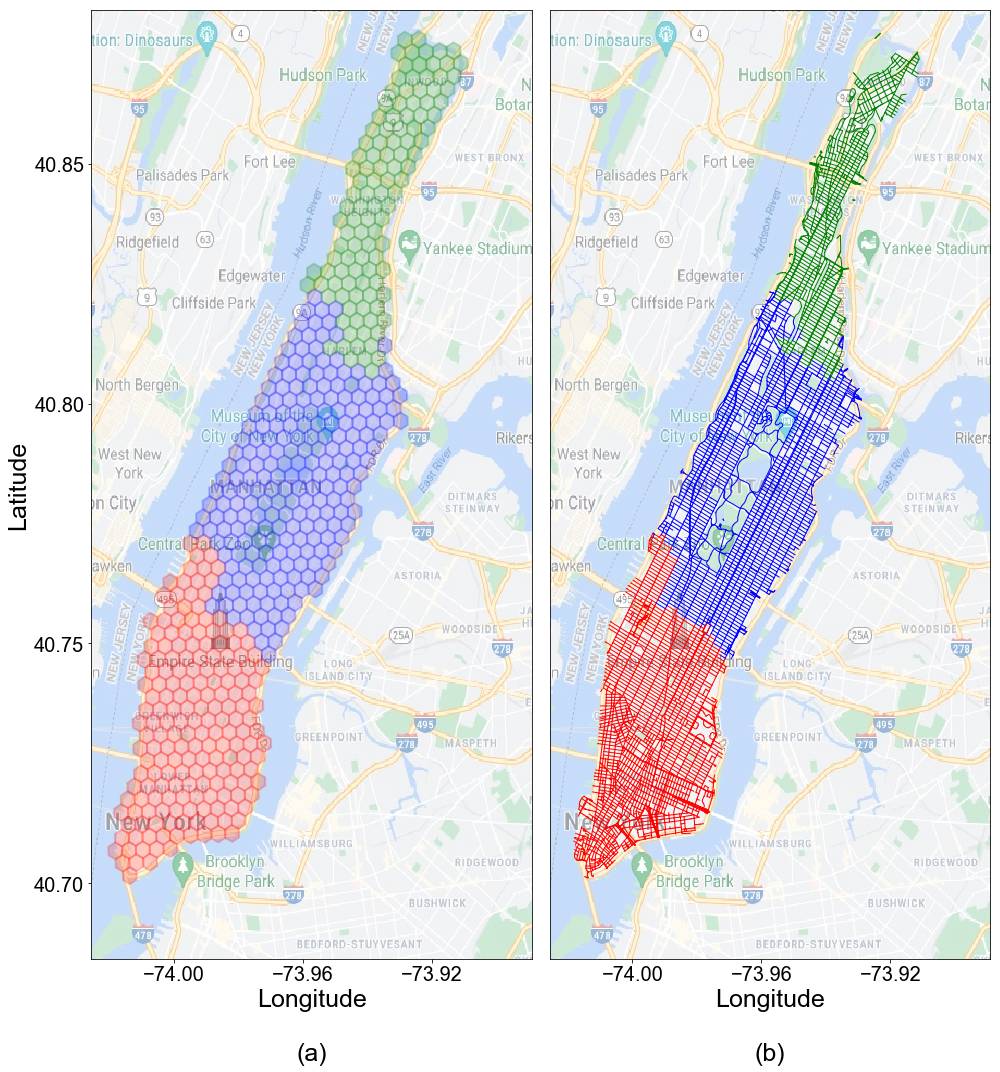

In [8]:
figure, ax1=Background('NYC',Southwest,Northeast)

Colors={'A':'r','B':'b','C':'g'}

    
for grid in Grid_label.keys():
    
    grid=str(grid)
    
    label=Grid_label[grid]

    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color=Colors[label],linewidth=2,fill=True,alpha=0.2)

    ax1[0].add_patch(pgon)
        
    
for idx,row in Street_data.iterrows():
    
    label=row['tag']
    
    lines=[arr for arr in list(row['geometry'].coords)]

    X_lines=[arr[0] for arr in lines]

    Y_lines=[arr[1] for arr in lines]

    ax1[1].plot(X_lines,Y_lines,color=Colors[label],linewidth=1)

        
plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

Save_path = './Real_World/'

current_fig.savefig(os.path.join(Save_path,'04Distribution.png'), format='png', bbox_inches = 'tight')

plt.show()





## Generate data

In [29]:
import datetime

'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]

'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
Weekdays

['2020-12-01',
 '2020-12-02',
 '2020-12-03',
 '2020-12-04',
 '2020-12-07',
 '2020-12-08',
 '2020-12-09',
 '2020-12-10',
 '2020-12-11',
 '2020-12-14',
 '2020-12-15',
 '2020-12-16',
 '2020-12-17',
 '2020-12-18',
 '2020-12-21',
 '2020-12-22',
 '2020-12-23',
 '2020-12-24',
 '2020-12-25',
 '2020-12-28',
 '2020-12-29',
 '2020-12-30',
 '2020-12-31']

In [38]:
Label_grid={}

for grid,label in Grid_label.items():
    
    if label not in Label_grid.keys():
        
        Label_grid[label]=[grid]
        
    else:
        
        Label_grid[label].append(grid)

def Generate_grid(Label_grid):
    
    coin=random.random()
    
    if coin<=0.4:
        
        return random.choice(Label_grid['C'])
    
    elif coin> 0.4 and coin<=0.6:
        
        return random.choice(Label_grid['B'])
    
    else:
        
        return random.choice(Label_grid['A'])
    


for dt in Weekdays:
                 
    Driver_num=copy.deepcopy(ini_num)

    Driver_list=['D'+str(i) for i in range(Driver_num)]

    Driver_df=pd.DataFrame(Driver_list,columns=['Driver_id'])

    Driver_df['Grid']=Driver_df.apply(lambda x:str(random.choice(Grid_list)),axis=1)

    Driver_df['Point']=Driver_df.apply(lambda x:[p for p in h3.h3_to_geo(x['Grid'])],axis=1)

    Driver_df['Reposition_Point']=Driver_df.apply(lambda x:x['Point'],axis=1)

    Driver_df['Reposition_Grid']=Driver_df.apply(lambda x:x['Grid'],axis=1)

    Driver_df['Step']=Start_step

    Driver_df['Order_id']='Idle'

    Driver_df=Driver_df[['Driver_id','Order_id','Step','Point','Grid','Reposition_Point','Reposition_Grid']]


    '''Generate Vehicles by minute'''

    Arrival_rate={}

    Minute_step={}

    for step in range(Start_step,End_step):

        minute=int((step-2520)/6)

        if minute not in Minute_step.keys():

            Minute_step[minute]=[step]

            if minute<=30:

                arrival_rate=random.choice(list(range(7,20,1)))

            elif minute>30 and minute<=90:

                arrival_rate=random.choice(list(range(1,8,1)))

            else:

                arrival_rate=random.choice(list(range(5,13,1))) 

        else:

            Minute_step[minute].append(step)
            
        Arrival_rate[minute]=arrival_rate


    Arrival_rate_step={}

    for minute in Minute_step.keys():

        total_arrival=Arrival_rate[minute]

        sum__arrival=0

        for step in Minute_step[minute]:

            if Minute_step[minute].index(step)==5:

                arrival_rate=total_arrival-sum__arrival

            else:
                arrival_rate=random.choice(list(range(5)))

                while sum__arrival+arrival_rate>total_arrival:

                    arrival_rate=random.choice(list(range(5)))

            sum__arrival+=arrival_rate

            Arrival_rate_step[step]=arrival_rate


    for step in range(Start_step,End_step):

        rate=Arrival_rate_step[step]

        if rate>0:

            for i in range(rate):

                Added_item={}

                driver_id='D'+str(Driver_num)

                Added_item['Driver_id']=driver_id

                Added_item['Order_id']='Idle'

                Added_item['Step']=step

                grid=str(Generate_grid(Label_grid))

                pnt=[p for p in h3.h3_to_geo(grid)]

                Added_item['Point']=pnt

                Added_item['Grid']=grid

                Added_item['Reposition_Point']=pnt

                Added_item['Reposition_Grid']=grid

                Driver_df=Driver_df.append(Added_item, ignore_index=True)

                Driver_num+=1

    Driver_df.to_csv('./Data/NYC_2020/Driver_df_'+str(dt)+'.csv')
    
    print(dt)

Driver_df


2020-12-01
2020-12-02
2020-12-03
2020-12-04
2020-12-07
2020-12-08
2020-12-09
2020-12-10
2020-12-11
2020-12-14
2020-12-15
2020-12-16
2020-12-17
2020-12-18
2020-12-21
2020-12-22
2020-12-23
2020-12-24
2020-12-25
2020-12-28
2020-12-29
2020-12-30
2020-12-31


Driver_id Order_id  Step                                     Point  \
0           D0     Idle  2520  [40.796267321184985, -73.93398840494557]   
1           D1     Idle  2520   [40.72798555551391, -74.01481797231989]   
2           D2     Idle  2520   [40.76307233809355, -73.98838407088252]   
3           D3     Idle  2520  [40.762840657279746, -73.99693830224494]   
4           D4     Idle  2520  [40.766002576302085, -73.97779433265362]   
...        ...      ...   ...                                       ...   
1532     D1532     Idle  3598   [40.74498799569922, -73.97269448397235]   
1533     D1533     Idle  3598   [40.86286887873377, -73.91722159291291]   
1534     D1534     Idle  3599  [40.833157976688156, -73.93968267792161]   
1535     D1535     Idle  3599   [40.80166621211985, -73.92990922815342]   
1536     D1536     Idle  3599   [40.82471307371089, -73.95865174057755]   

                 Grid                          Reposition_Point  \
0     892a1008da3ffff  [40.796267321184985, -73.93398840494557]   
1     892a1072c5bffff   [40.72798555551391, -74.01481797231989]   
2     892a100d64bffff   [40.76307233809355, -73.98838407088252]   
3     892a107258fffff  [40.762840657279746, -73.99693830224494]   
4     892a100d6cfffff  [40.766002576302085, -73.97779433265362]   
...               ...                                       ...   
1532  892a100d04bffff   [40.74498799569922, -73.97269448397235]   
1533  892a100a12fffff   [40.86286887873377, -73.91722159291291]   
1534  892a100aaabffff  [40.833157976688156, -73.93968267792161]   
1535  892a100f64bffff   [40.80166621211985, -73.92990922815342]   
1536  892a1008cd7ffff   [40.82471307371089, -73.95865174057755]   

      Reposition_Grid  
0     892a1008da3ffff  
1     892a1072c5bffff  
2     892a100d64bffff  
3     892a107258fffff  
4     892a100d6cfffff  
...               ...  
1532  892a100d04bffff  
1533  892a100a12fffff  
1534  892a100aaabffff  
1535  892a100f64bffff  
1536  892a1008cd7ffff  

[1537 rows x 7 columns]

In [39]:
def Get_Region(grid,Label_grid):
    
    if grid in Label_grid['A']:
        
        return 'A'
    
    elif grid in Label_grid['B']:
        
         return 'B'
        
    else:
        
         return 'C'

Driver_df['Region']=Driver_df.apply(lambda x:Get_Region(x['Grid'],Label_grid),axis=1)

Driver_df.groupby('Region').count()


Driver_id  Order_id  Step  Point  Grid  Reposition_Point  \
Region                                                             
A             592       592   592    592   592               592   
B             320       320   320    320   320               320   
C             625       625   625    625   625               625   

        Reposition_Grid  
Region                   
A                   592  
B                   320  
C                   625

## Figure Plotting

In [40]:
inital_step=2520

def Get_minute(step):
    
    return int((step-inital_step)/6)


Driver_DF=pd.DataFrame([],columns=['Driver_id', 'Order_id', 'Step', 'Point', 'Grid', 'Reposition_Point',
       'Reposition_Grid','Day'],dtype=object)


for dt in Weekdays:

    Driver_df=pd.read_csv('./Data/NYC_2020/Driver_df_'+str(dt)+'.csv')
    
    Driver_df=Driver_df.drop(columns=['Unnamed: 0'])
    
    Driver_df['Day']=dt
    
    Driver_DF=pd.concat([Driver_DF,Driver_df],ignore_index=True)
    


Driver_STAT=Driver_df.groupby(['Step']).count()

Driver_STAT['Step']=Driver_STAT.index

Driver_STAT=Driver_STAT.reset_index(drop=True)

Driver_STAT['Driver_num']=ini_num

for idx,col in Driver_STAT.iterrows():
    
    if idx!=0:
    
        Driver_STAT.loc[idx,'Driver_num']=Driver_STAT.loc[idx-1,'Driver_num']+Driver_STAT.loc[idx,'Driver_id']

Driver_STAT['minute']=Driver_STAT.apply(lambda x:Get_minute(x['Step']),axis=1)

Driver_STAT=Driver_STAT.drop_duplicates(subset=['minute'], keep='last')

Driver_STAT=Driver_STAT.reset_index(drop=True)

Driver_STAT=Driver_STAT[['minute','Driver_num']]

Driver_STAT['Arriving']=0

for idx,col in Driver_STAT.iterrows():
    
    if idx!=0:
    
        Driver_STAT.loc[idx,'Arriving']=Driver_STAT.loc[idx,'Driver_num']-Driver_STAT.loc[idx-1,'Driver_num']
        
    else:
        
        Driver_STAT.loc[idx,'Arriving']=Driver_STAT.loc[idx,'Driver_num']-ini_num

Driver_STAT[['Driver_num']] = Driver_STAT[['Driver_num']].astype(int)

Driver_STAT[['Arriving']] = Driver_STAT[['Arriving']].astype(int)

Driver_STAT


minute  Driver_num  Arriving
0         0         159         9
1         1         169        10
2         2         179        10
3         3         196        17
4         4         203         7
..      ...         ...       ...
175     175        1500         6
176     176        1509         9
177     177        1515         6
178     178        1525        10
179     179        1537        12

[180 rows x 3 columns]

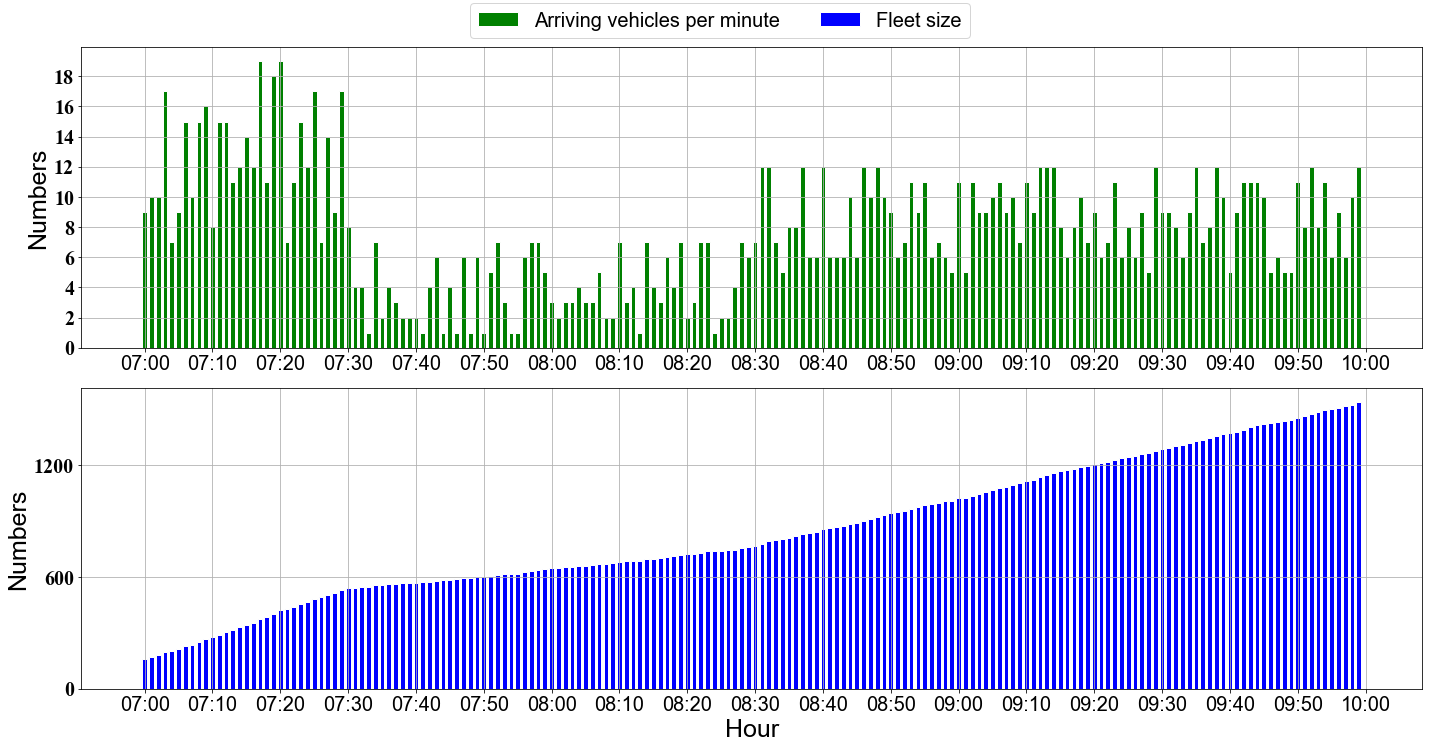

In [41]:
'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    

'''Plot'''

cumulative=[0  for i in list(Driver_STAT['minute'])]

ax1[0].bar(Driver_STAT['minute'],\
        Driver_STAT['Arriving'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        edgecolor = 'white',\
        label='Arriving vehicles per minute')
    


xmajorLocator   = MultipleLocator(10)

ax1[0].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(2)

ax1[0].yaxis.set_major_locator(ymajorLocator1)

ax1[0].set_ylabel('Numbers',font_label)

ax1[0].grid()

ax1[0].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)



cumulative=[0  for i in list(Driver_STAT['minute'])]

ax1[1].bar(Driver_STAT['minute'],\
        Driver_STAT['Driver_num'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'b',\
        edgecolor = 'white',\
        label='Fleet size')
    


xmajorLocator   = MultipleLocator(10)

ax1[1].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(600)

ax1[1].yaxis.set_major_locator(ymajorLocator1)

ax1[1].set_ylabel('Numbers',font_label)

ax1[1].set_xlabel('Hour',font_label)

ax1[1].grid()

ax1[1].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.05),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Save_path,'Supply.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()

## Figure Heatmap

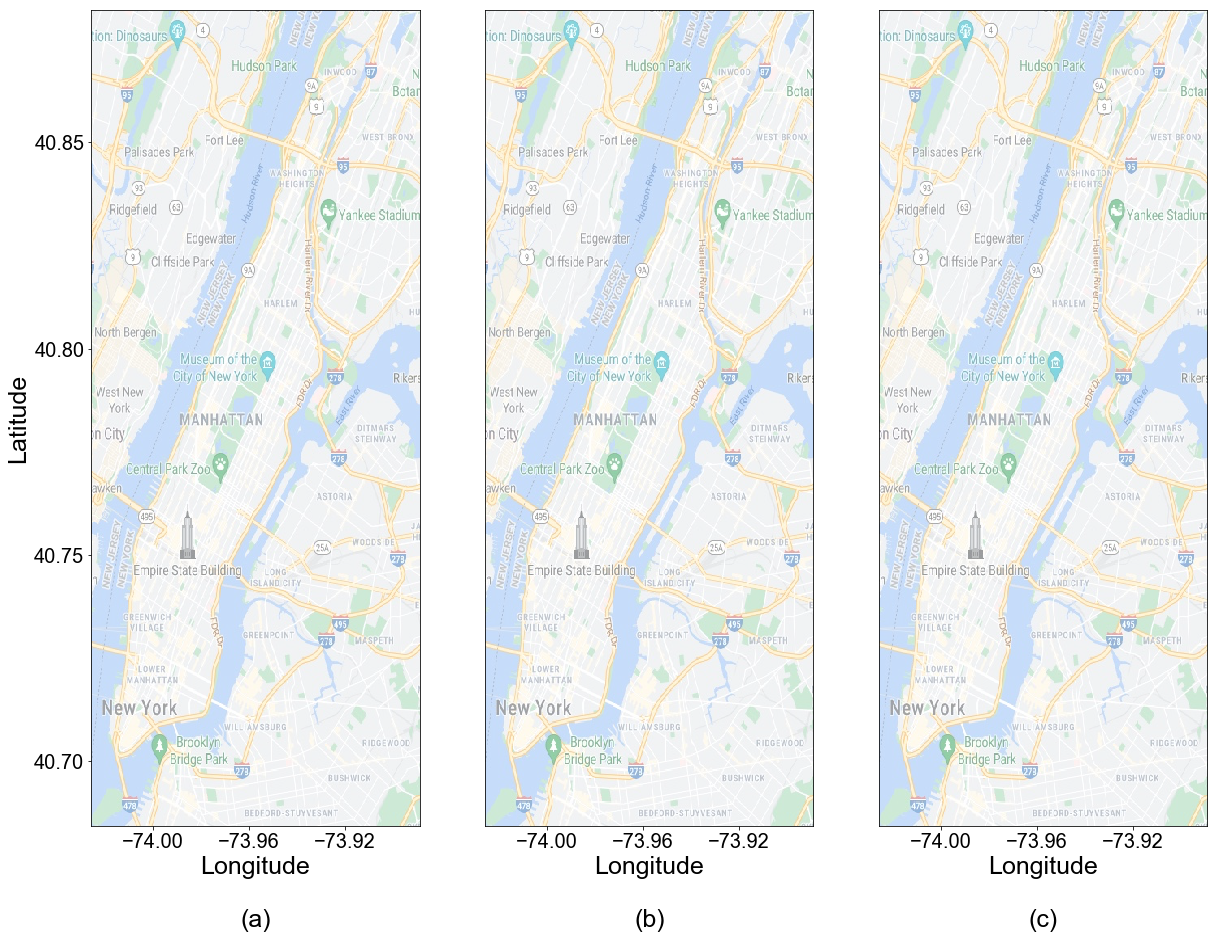

In [42]:

tags=['\n\n(a)','\n\n(b)','\n\n(c)']

Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./Data/Map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}


def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 20,15
    
    figure, ax1 = plt.subplots(1,3,figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    
    for i in range(3):

        labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Arial') for label in labels]
        
        ax1[i].set_xlim(xgrange)
        
        ax1[i].set_ylim(ygrange)
        
        x0,x1 = ax1[i].get_xlim()
        
        y0,y1 = ax1[i].get_ylim()
    
        ax1[i].imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
        
        ax1[i].set_xlabel('Longitude'+tags[i],font_label)
        
        xmajorLocator   = MultipleLocator(0.04)

        ax1[i].xaxis.set_major_locator(xmajorLocator)

        if i>0:
        
            ax1[i].set_yticks([])
            
        else:
            
            ax1[i].set_ylabel('Latitude',font_label)
            
            ymajorLocator1   = MultipleLocator(0.05)

            ax1[i].yaxis.set_major_locator(ymajorLocator1)
    
    return figure, ax1


figure, ax1=Background('NYC',Southwest,Northeast)





In [43]:
Driver_STAT=Driver_DF.groupby(['Grid']).count()

Driver_STAT['Grid']=Driver_STAT.index

Driver_STAT=Driver_STAT.reset_index(drop=True)

Driver_STAT=Driver_STAT.rename(columns={'Driver_id':'Driver_Num'})

Driver_STAT=Driver_STAT[['Grid','Driver_Num']]

Driver_STAT['Driver_Num']=Driver_STAT['Driver_Num']/len(Weekdays)

Driver_STAT[['Driver_Num']] = Driver_STAT[['Driver_Num']].astype(int)

Driver_STAT['ratio']=Driver_STAT.apply(lambda x:(x['Driver_Num']-min(Driver_STAT['Driver_Num']))/(max(Driver_STAT['Driver_Num'])-min(Driver_STAT['Driver_Num'])),axis=1)

Driver_STAT






Order_DF=pd.DataFrame([],columns=['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
   'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
   'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
   'Dropoff_Point', 'Travel_dis', 'Travel_time','date'],dtype=object)
        
for dt in Weekdays:
    
    Order_df=pd.read_csv('./Data/NYC_2020/Order_df_'+str(dt)+'.csv')

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_df=Order_df.loc[(Order_df['Arrive_step']>=Start_step)&(Order_df['Arrive_step']<End_step)]
    
    Order_DF=pd.concat([Order_DF,Order_df],ignore_index=True)
    


Origin_STAT=Order_DF.groupby(['Pickup_Grid']).count()

Origin_STAT['Grid']=Origin_STAT.index

Origin_STAT=Origin_STAT.reset_index(drop=True)

Origin_STAT=Origin_STAT.rename(columns={'Order_id':'Order_Num'})

Origin_STAT=Origin_STAT[['Grid','Order_Num']]

Origin_STAT['Order_Num']=Origin_STAT.apply(lambda x:x['Order_Num']/len(Weekdays),axis=1)

Origin_STAT['ratio']=Origin_STAT.apply(lambda x:(x['Order_Num']-min(Origin_STAT['Order_Num']))/(max(Origin_STAT['Order_Num'])-min(Origin_STAT['Order_Num'])),axis=1)



Destination_STAT=Order_DF.groupby(['Dropoff_Grid']).count()

Destination_STAT['Grid']=Destination_STAT.index

Destination_STAT=Destination_STAT.reset_index(drop=True)

Destination_STAT=Destination_STAT.rename(columns={'Order_id':'Order_Num'})

Destination_STAT=Destination_STAT[['Grid','Order_Num']]

Destination_STAT['Order_Num']=Destination_STAT.apply(lambda x:x['Order_Num']/len(Weekdays),axis=1)

Destination_STAT['ratio']=Destination_STAT.apply(lambda x:(x['Order_Num']-min(Destination_STAT['Order_Num']))/(max(Destination_STAT['Order_Num'])-min(Destination_STAT['Order_Num'])),axis=1)



Destination_STAT





Grid  Order_Num     ratio
0    892a10085a7ffff   0.043478  0.000000
1    892a10085b7ffff   0.043478  0.000000
2    892a1008803ffff  10.043478  0.133566
3    892a1008807ffff  14.956522  0.199187
4    892a100880bffff   0.260870  0.002904
..               ...        ...       ...
599  892a1072dd3ffff   1.217391  0.015679
600  892a1072dd7ffff   1.434783  0.018583
601  892a1072ddbffff   2.043478  0.026713
602  892a1072ea7ffff   0.652174  0.008130
603  892a1072eb7ffff   0.217391  0.002323

[604 rows x 3 columns]

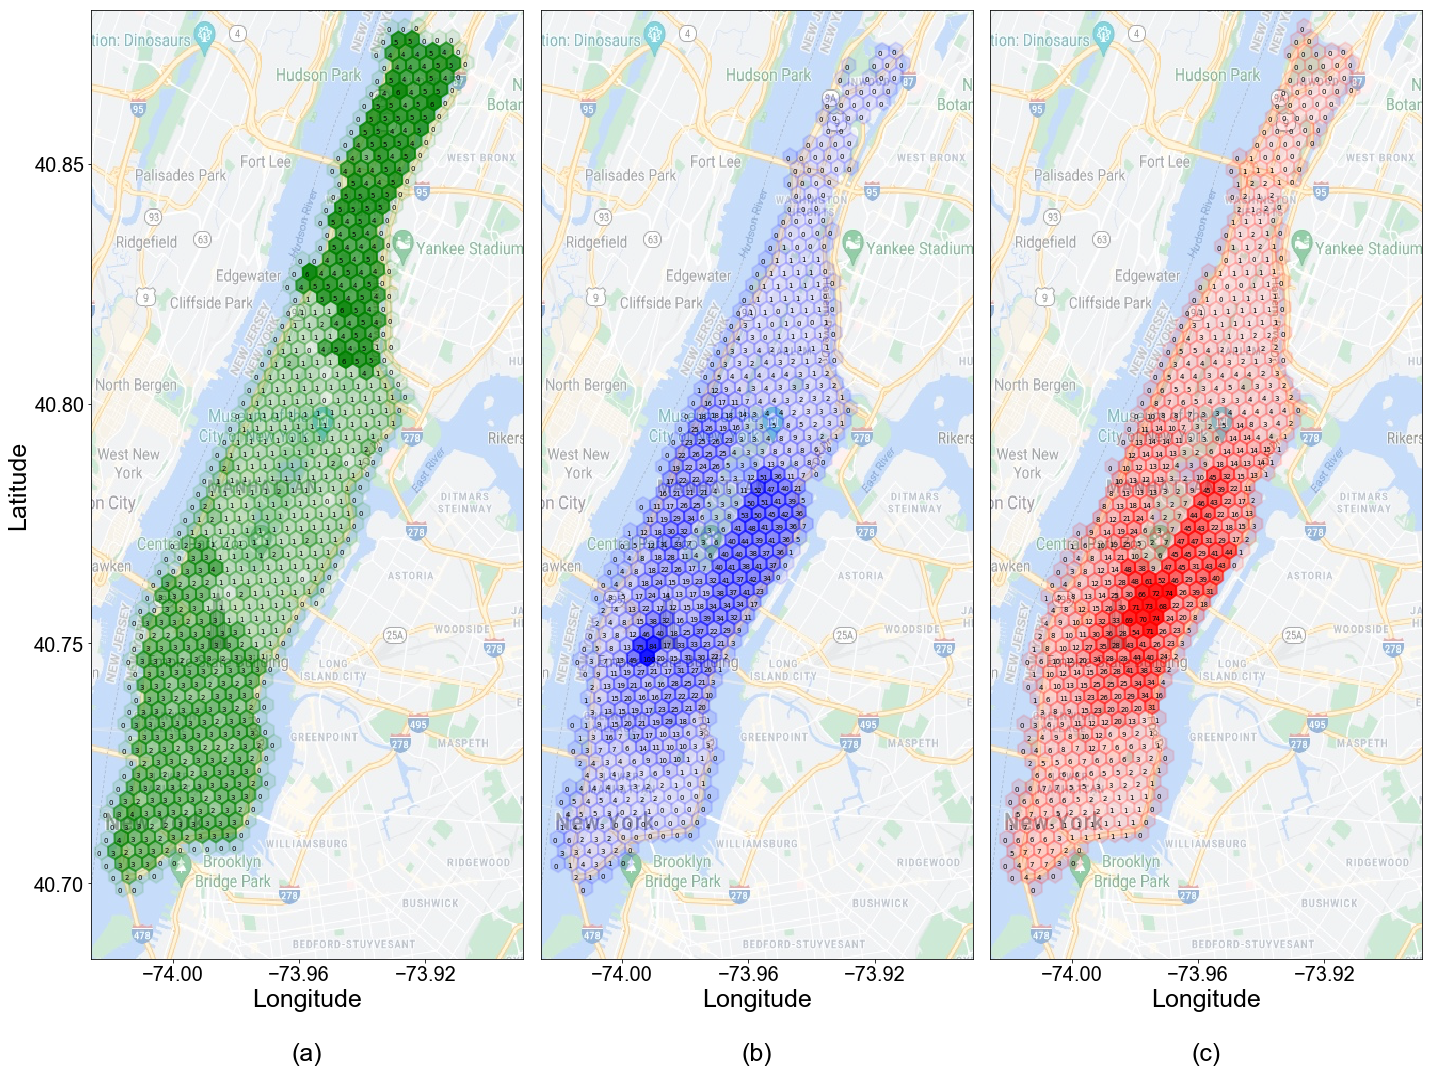

In [44]:
'''Heatmap'''

figure, ax1=Background('NYC',Southwest,Northeast)

for idx,row in Driver_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=row['Driver_Num']
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='green',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1[0].add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1[0].annotate(s=str(num),fontsize=7,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    
    
'''Heatmap'''

for idx,row in Origin_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=int(row['Order_Num'])
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='blue',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1[1].add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1[1].annotate(s=str(num),fontsize=7,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    
    
'''Heatmap'''

for idx,row in Destination_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=int(row['Order_Num'])
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='red',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1[2].add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1[2].annotate(s=str(num),fontsize=7,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    
    
    

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Spatial.png', format='png',bbox_inches = 'tight')

plt.show()
